In [1]:
from bayes_opt import BayesianOptimization
import numpy as np

import matplotlib.pyplot as plt
from matplotlib import gridspec
%matplotlib inline

# plt.style.use(['dark_background'])

# Target Function

Lets create a target 1-D function with multiple local maxima to test and visualize how the [BayesianOptimization](https://github.com/fmfn/BayesianOptimization) package works. The target function we will try to maximize is the following:

$$f(x) = e^{-(x - 2)^2} + e^{-\frac{(x - 6)^2}{10}} + \frac{1}{x^2 + 1}, $$ its maximum is at $x = 2$ and we will restrict the interval of interest to $x \in (-2, 10)$.

Notice that, in practice, this function is unknown, the only information we have is obtained by sequentialy probing it at different points. Bayesian Optimization works by contructing a posterior distribution of functions that best fit the data observed and chosing the next probing point by balancing exploration and exploitation.

In [4]:
def target(x):
    return np.exp(-(x - 2)**2) + np.exp(-(x - 6)**2/10) + 1/ (x**2 + 1)

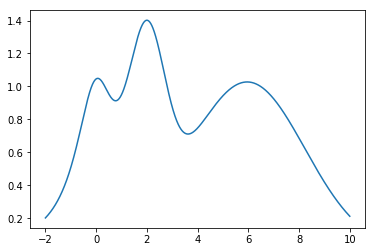

In [5]:
x = np.linspace(-2, 10, 10000).reshape(-1, 1)
y = target(x)

plt.plot(x, y)

In [9]:
bo = BayesianOptimization(target, {'x': (-2, 10)})

In this example we will use the Upper Confidence Bound (UCB) as our utility function. It has the free parameter
$\kappa$ which control the balance between exploration and exploitation; we will set $\kappa=5$ which, in this case, makes the algorithm quite bold. Additionally we will use the cubic correlation in our Gaussian Process.

In [10]:
bo.maximize(init_points=2, n_iter=0, acq='ucb', kappa=5)

Initialization
-----------------------------------------
 Step |   Time |      Value |         x | 
    1 | 00m00s |    0.76364 |    7.7075 | 
    2 | 00m00s |    1.33616 |    2.2809 | 
Bayesian Optimization
-----------------------------------------
 Step |   Time |      Value |         x | 


# Plotting and visualizing the algorithm at each step

### Lets first define a couple functions to make plotting easier

In [11]:
def posterior(bo, x, xmin=-2, xmax=10):
    xmin, xmax = -2, 10
    bo.gp.fit(bo.X, bo.Y)
    mu, sigma = bo.gp.predict(x, return_std=True)
    return mu, sigma

def plot_gp(bo, x, y):
    
    fig = plt.figure(figsize=(16, 10))
    fig.suptitle('Gaussian Process and Utility Function After {} Steps'.format(len(bo.X)), fontdict={'size':30})
    
    gs = gridspec.GridSpec(2, 1, height_ratios=[3, 1]) 
    axis = plt.subplot(gs[0])
    acq = plt.subplot(gs[1])
    
    mu, sigma = posterior(bo, x)
    axis.plot(x, y, linewidth=3, label='Target')
    axis.plot(bo.X.flatten(), bo.Y, 'D', markersize=8, label=u'Observations', color='r')
    axis.plot(x, mu, '--', color='k', label='Prediction')

    axis.fill(np.concatenate([x, x[::-1]]), 
              np.concatenate([mu - 1.9600 * sigma, (mu + 1.9600 * sigma)[::-1]]),
        alpha=.6, fc='c', ec='None', label='95% confidence interval')
    
    axis.set_xlim((-2, 10))
    axis.set_ylim((None, None))
    axis.set_ylabel('f(x)', fontdict={'size':20})
    axis.set_xlabel('x', fontdict={'size':20})
    
    utility = bo.util.utility(x, bo.gp, 0)
    acq.plot(x, utility, label='Utility Function', color='purple')
    acq.plot(x[np.argmax(utility)], np.max(utility), '*', markersize=15, 
             label=u'Next Best Guess', markerfacecolor='gold', markeredgecolor='k', markeredgewidth=1)
    acq.set_xlim((-2, 10))
    acq.set_ylim((0, np.max(utility) + 0.5))
    acq.set_ylabel('Utility', fontdict={'size':20})
    acq.set_xlabel('x', fontdict={'size':20})
    
    axis.legend(loc=2, bbox_to_anchor=(1.01, 1), borderaxespad=0.)
    acq.legend(loc=2, bbox_to_anchor=(1.01, 1), borderaxespad=0.)

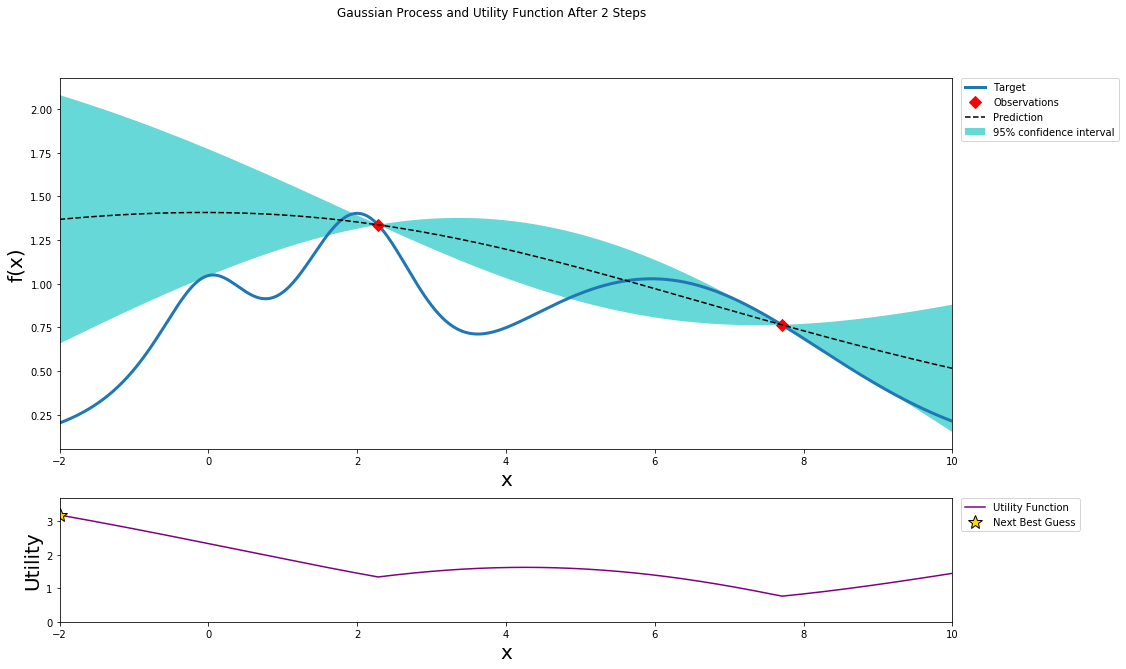

In [12]:
plot_gp(bo, x, y)

### After one step of GP (and two random points)

Bayesian Optimization
-----------------------------------------
 Step |   Time |      Value |         x | 
   11 | 00m01s |    0.46622 |    8.8120 | 


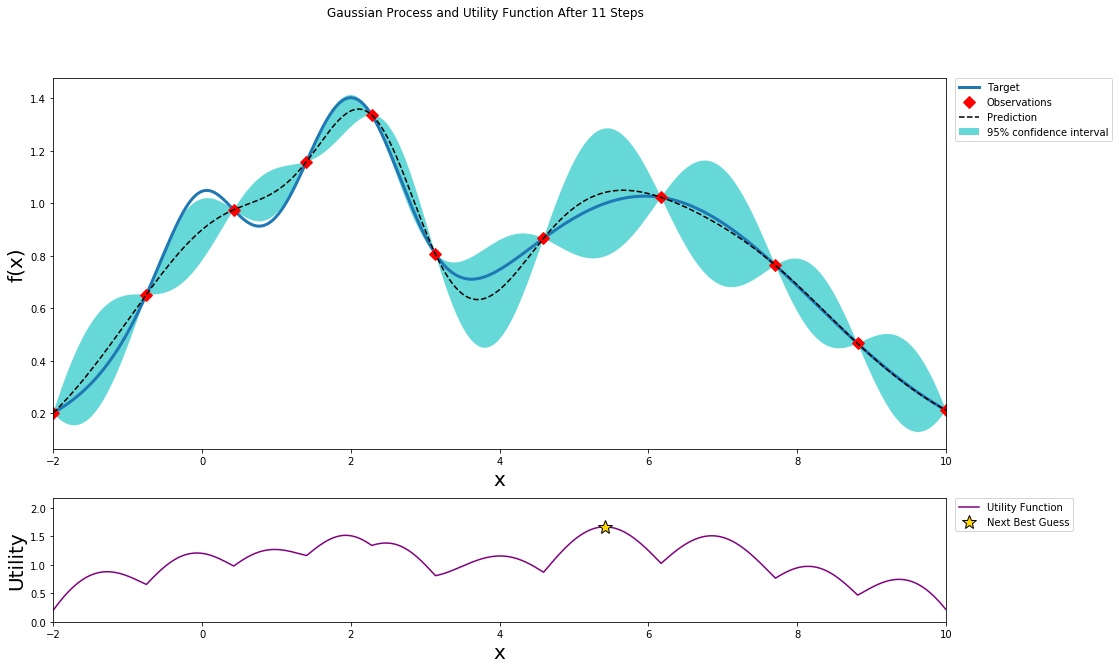

In [21]:
bo.maximize(init_points=0, n_iter=1, kappa=5)
plot_gp(bo, x, y)

### After two steps of GP (and two random points)

### After three steps of GP (and two random points)

### After four steps of GP (and two random points)

### After five steps of GP (and two random points)

Bayesian Optimization
-----------------------------------------
 Step |   Time |      Value |         x | 
    8 | 00m01s |    1.02269 |    6.1704 | 


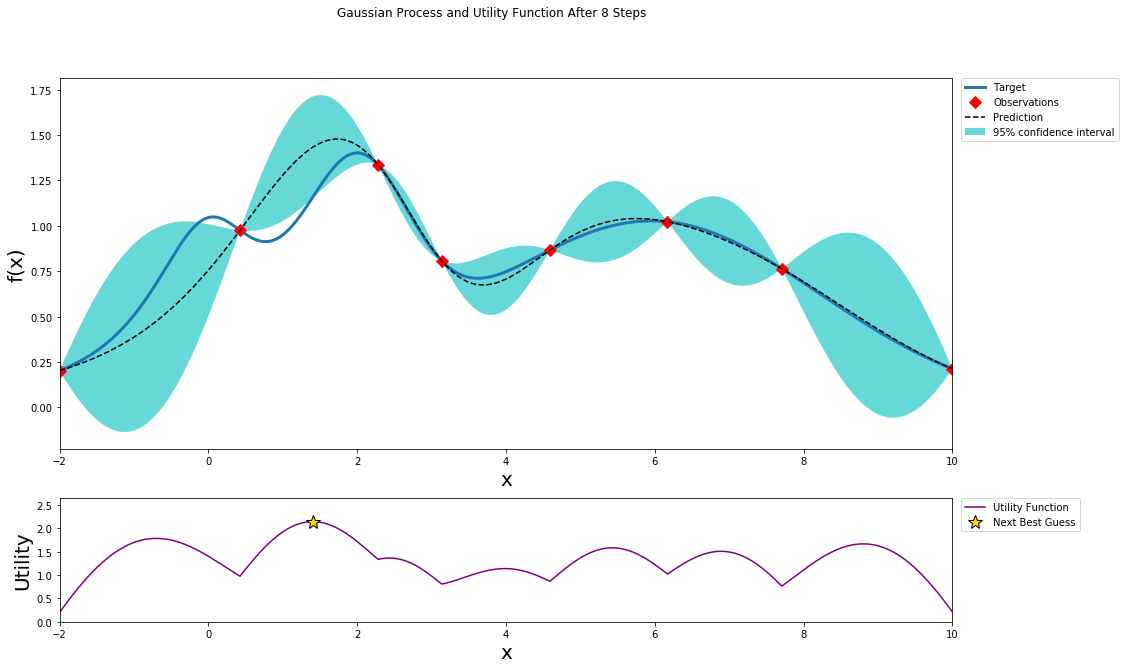

### After six steps of GP (and two random points)

# Stopping

After just a few points the algorithm was able to get pretty close to the true maximum. It is important to notice that the trade off between exploration (exploring the parameter space) and exploitation (probing points near the current known maximum) is fundamental to a succesful bayesian optimization procedure. The utility function being used here (Upper Confidence Bound - UCB) has a free parameter $\kappa$ that allows the user to make the algorithm more or less conservative. Additionally, a the larger the initial set of random points explored, the less likely the algorithm is to get stuck in local minima due to being too conservative.